# CAB420 Practical 7 - Question 1 Solution
## Deep Face Recognition

Using the YaleB_32x32.mat data, train a Siamese network to match faces of the same subject. In doing this you should:
* Determine your network architecture, i.e. pairs or triplets, and loss formulation. You may also wish to fine tune an existing network.
* Implement (or modify) an appropriate method to generate pairs/triplets of images, and verify that this is generating pairs/triplets as expected.

Using your trained network, evaluate it and compare the performance to the PCA and LDA approaches from last week. Note that you can train a CKNN classifier to replicate the functionality of last week's approaches by:
* Passing each image through the network to generate an embedding;
* Applying CKNN to the embeddings.

As per last week, evaluate the performance on the Yale and ORL datasets.

In [1]:
import os
# why is this here? This is disabling some tensorflow warning I get in some of my environments that 
# annoy me (look ugly and untidy really)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import random
import numpy
import numpy.matlib
import scipy
import matplotlib.pyplot as plt

import keras
from keras import layers
from keras import backend as K

from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay

# for consistency
random.seed(4)

## Data Setup

This is a variation on how we've handeled the data for the week 6 practials. Here we will:
* Load the data
* Scale the image data to [0..1]
* Select some subjects for the test set and split the data
* Create a reshaped version of the data to get the data into an 'image' shape for input to our deep net

In [2]:
yale_b = scipy.io.loadmat('YaleB_32x32.mat')
fea = yale_b['fea'] / 255.0
gnd = numpy.array(yale_b['gnd'])

test_frames = numpy.array(()).astype('int')
for i in numpy.unique(gnd):    
    indexes = numpy.where(gnd == i)[0]
    count = len(indexes);
    f = numpy.random.randint(count, size=6)
    test_frames = numpy.append(test_frames, indexes[f])

train_fea = fea
train_gnd = gnd
train_fea = numpy.delete(train_fea, test_frames, 0)
train_gnd = numpy.delete(train_gnd, test_frames, 0)
test_fea = fea[test_frames, :]
test_gnd = gnd[test_frames, :]
train_gnd = numpy.reshape(train_gnd, -1)
test_gnd = numpy.reshape(test_gnd, -1)

train_fea_reshape = numpy.reshape(train_fea.transpose(), (32, 32, 1, len(train_fea)))
train_fea_reshape = numpy.transpose(train_fea_reshape, (3, 1, 0, 2))
test_fea_reshape = numpy.reshape(test_fea.transpose(), (32, 32, 1, len(test_fea)))
test_fea_reshape = numpy.transpose(test_fea_reshape, (3, 1, 0, 2))

For the sake of sanity, we'll visualise the data to make sure that our reshape has worked. Note that you should always check these things - it's very easy to make a mistake.

We'll run this check on both the training and testing sets.

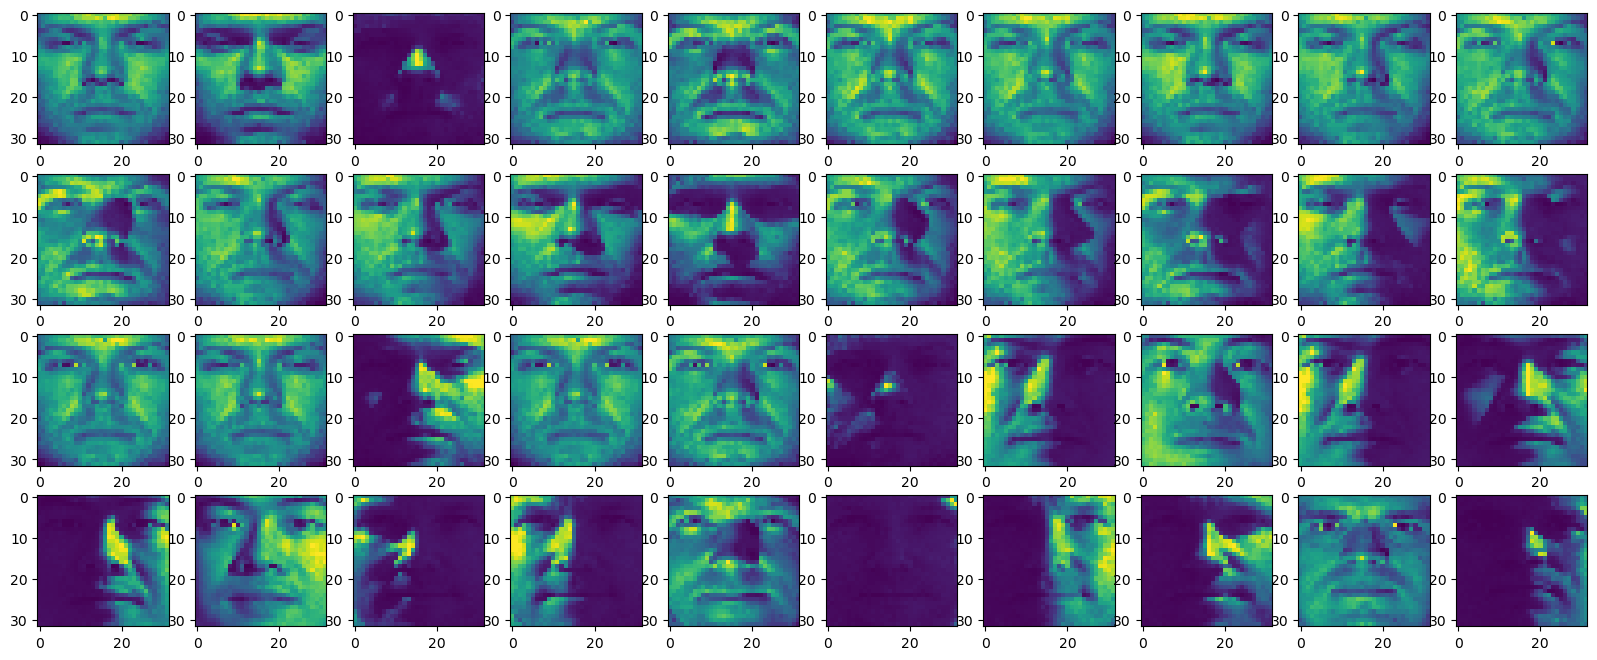

In [3]:
fig = plt.figure(figsize=[20, 8])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(train_fea_reshape[i,:,:,0])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 21)
    ax.imshow(test_fea_reshape[i,:,:,0])    

## Network Setup

We're going to use a Siamese network, and so we're going to borrow heavily from the lecture example.

The following set of functions and network setup is taken directly from the Siamese network example.

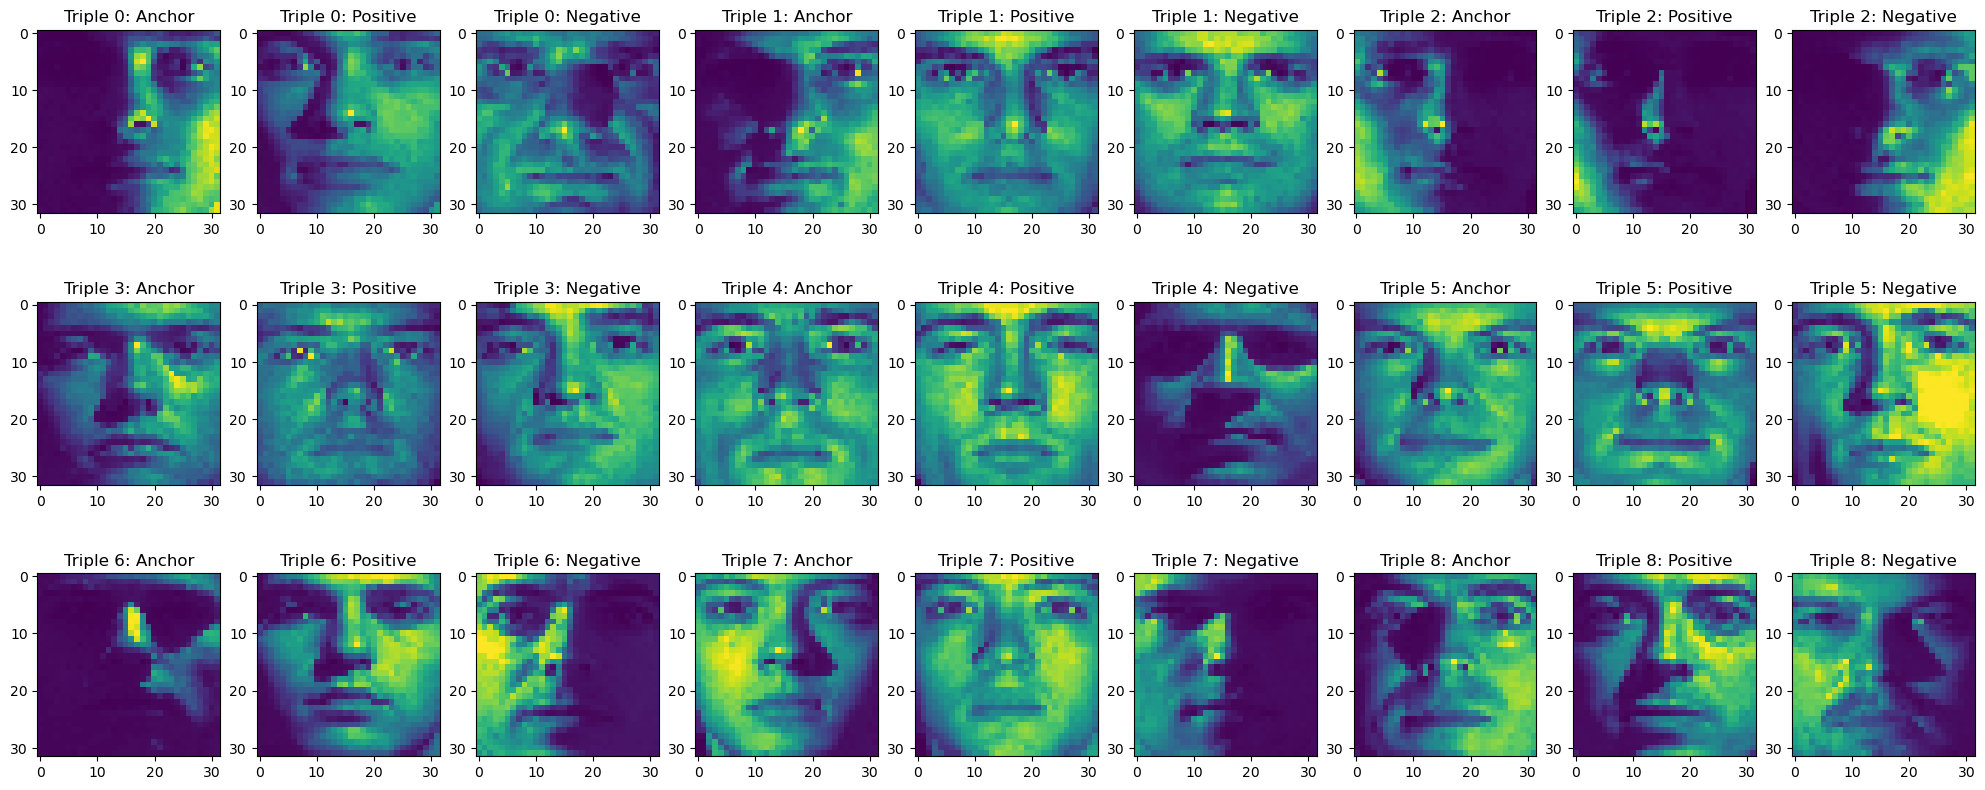

In [4]:
def GetSiameseData(imgs, labels, batch_size):

    image_a = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_b = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    label = numpy.zeros(batch_size);
    
    for i in range(batch_size):
        
        if (i % 2 == 0):
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 1
            while (labels[idx1] != labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)            
                
        else:
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 0
            while (labels[idx1] == labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        label[i] = l

    return [image_a, image_b], label

def GetTripletData(imgs, labels, batch_size):

    image_a = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_b = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_c = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    
    for i in range(batch_size):
        
        idx1 = random.randint(0, len(imgs) - 1)
        idx2 = random.randint(0, len(imgs) - 1)
        idx3 = random.randint(0, len(imgs) - 1)

        while (labels[idx1] != labels[idx2]):
            idx2 = random.randint(0, len(imgs) - 1)            
                
        while (labels[idx1] == labels[idx3]):
            idx3 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        image_c[i, :, :, :] = imgs[idx3,:,:,:]

    return [image_a, image_b, image_c]
        
x = GetTripletData(train_fea_reshape, train_gnd, 9)

fig = plt.figure(figsize=[25, 10])
for i in range(9):
    ax = fig.add_subplot(3, 9, i*3 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Triple ' + str(i) + ': Anchor')
    
    ax = fig.add_subplot(3, 9, i*3 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('Triple ' + str(i) + ': Positive')

    ax = fig.add_subplot(3, 9, i*3 + 3)
    ax.imshow(x[2][i,:,:,0])    
    ax.set_title('Triple ' + str(i) + ': Negative')        

In [5]:
def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):
    
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

In [6]:
embedding_size = 32
dummy_input = keras.Input((32, 32, 1))
base_network = vgg_net(dummy_input, [8, 16, 32], [256], 0.2, 0)
embedding_layer = layers.Dense(embedding_size, activation=None)(base_network)
base_network = keras.Model(dummy_input, embedding_layer, name='SiameseBranch')

def normalise_vector(vect):
    # get the magnitude for each vector in the batch
    mag = keras.ops.sqrt(keras.ops.sum(keras.ops.square(vect), axis=1))
    # repeat this, so we now have as many elements in mag as we do in vect
    mag = keras.ops.reshape(keras.ops.repeat(mag, vect.shape[1], axis=0), (-1, vect.shape[1]))
    # element wise division
    return keras.ops.divide(vect, mag)

class TripletLossLayer(layers.Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        
        anchor = normalise_vector(anchor)
        positive = normalise_vector(positive)
        negative = normalise_vector(negative)

        p_dist = keras.ops.sum(keras.ops.square(anchor-positive), axis=-1)
        n_dist = keras.ops.sum(keras.ops.square(anchor-negative), axis=-1)
        return keras.ops.sum(keras.ops.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
        
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
    
input_anchor = keras.Input((32, 32, 1), name='Anchor')
input_positive = keras.Input((32, 32, 1), name='Positive')
input_negative = keras.Input((32, 32, 1), name='Negative')

embedding_anchor = base_network(input_anchor)
embedding_positive = base_network(input_positive)
embedding_negative = base_network(input_negative)

margin = 1
loss_layer = TripletLossLayer(alpha=margin, name='triplet_loss_layer')([embedding_anchor, embedding_positive, embedding_negative])

Now we can put the model together, and print the summary.

In [7]:
triplet_network = keras.Model(inputs=[input_anchor, input_positive, input_negative], outputs=loss_layer)
triplet_network.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ Anchor (InputLayer) │ (None, 32, 32, 1) │       0 │ -                    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Positive            │ (None, 32, 32, 1) │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Negative            │ (None, 32, 32, 1) │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ SiameseBranch       │ (None, 32)        │ 552,056 │ Anchor[0][0],        │
│ (Functional)        │                   │         │ Positive[0][0],      │
│                     │                   │         │ Negative[0][0]       │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ triplet_loss_layer  │ ()                │       0 │ SiameseBranch[0][0], │
│ (TripletLossLayer)  │                   │         │ SiameseBranch[1][0], │
│                     │                   │         │ SiameseBranch[2][0]  │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 552,056 (2.11 MB)

 Trainable params: 551,432 (2.10 MB)

 Non-trainable params: 624 (2.44 KB)

Finally we're up to model training. We'll train this for the same period of time we used in the lecture examples, but we'll make the validation set a bit smaller.

In [8]:
triplet_network.compile(optimizer=keras.optimizers.RMSprop())

batch_size = 128
triplet_train_x = GetTripletData(train_fea_reshape, train_gnd, 20000)
triplet_test_x = GetTripletData(test_fea_reshape, test_gnd, 1000)

triplet_network.fit(triplet_train_x, batch_size = 64, epochs=20, validation_data=(triplet_test_x, None))

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 49ms/step - loss: 53.3765 - val_loss: 18.1969
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 20.1697 - val_loss: 6.9227
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 9.6208 - val_loss: 4.4118
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.9261 - val_loss: 3.7944
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.3430 - val_loss: 3.2295
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.4112 - val_loss: 5.1876
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.7656 - val_loss: 1.6326
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.1274 - val_loss: 2.0606
Epoch 9/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.8212 - val_loss: 2.3915
Epoch 10/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.7052 - val_loss: 2.3969
Epoch 11/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.5722 - val_loss: 1.7228
Epoch 12/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms

### What Was Leaned?

For completeness, we'll have a look at the embeddings and see if we've managed to separate our classes.

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


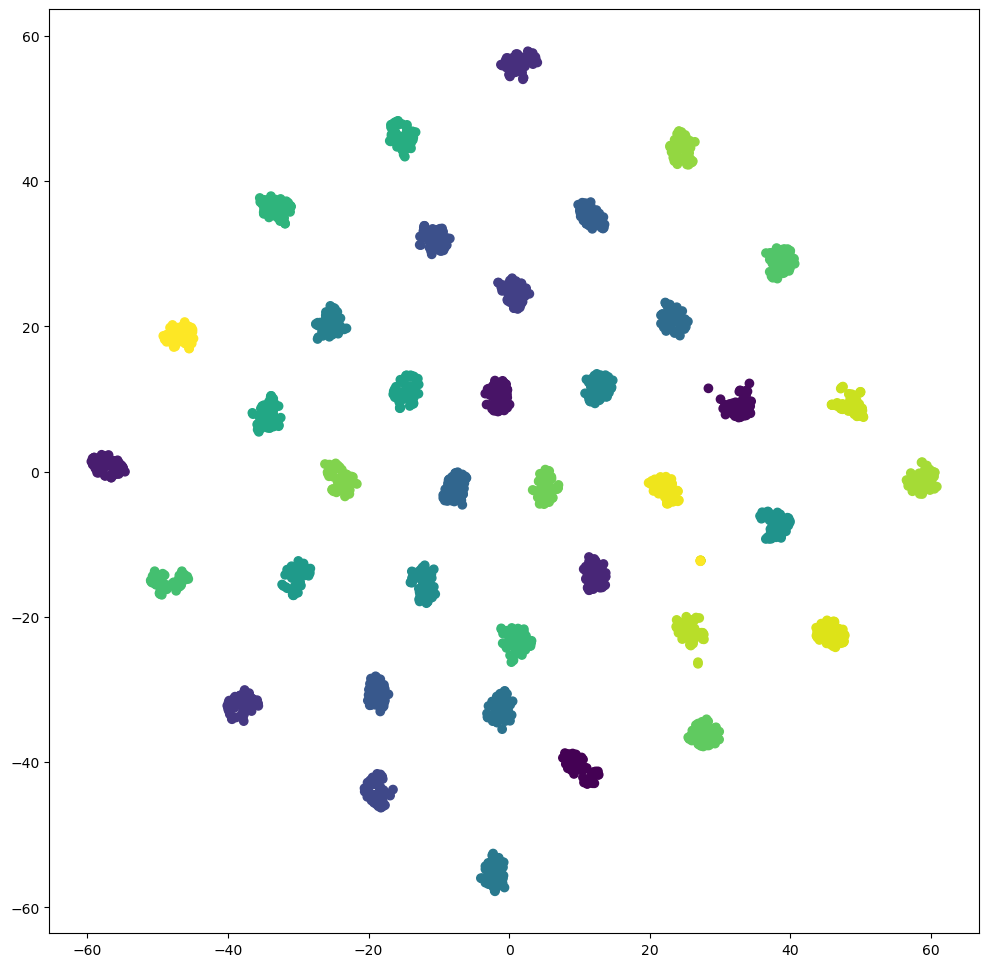

In [9]:
embeddings = base_network.predict(train_fea_reshape)
tsne_embeddings = TSNE(random_state=4).fit_transform(embeddings)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = train_gnd.flatten());

Our classes are very well separated. From this, it appears our network has worked.

Let's now do an evaluation for our classification problem. To keep this on an even footing with our PCA and LDA methods, we'll just consider a simple CKNN classifier.

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


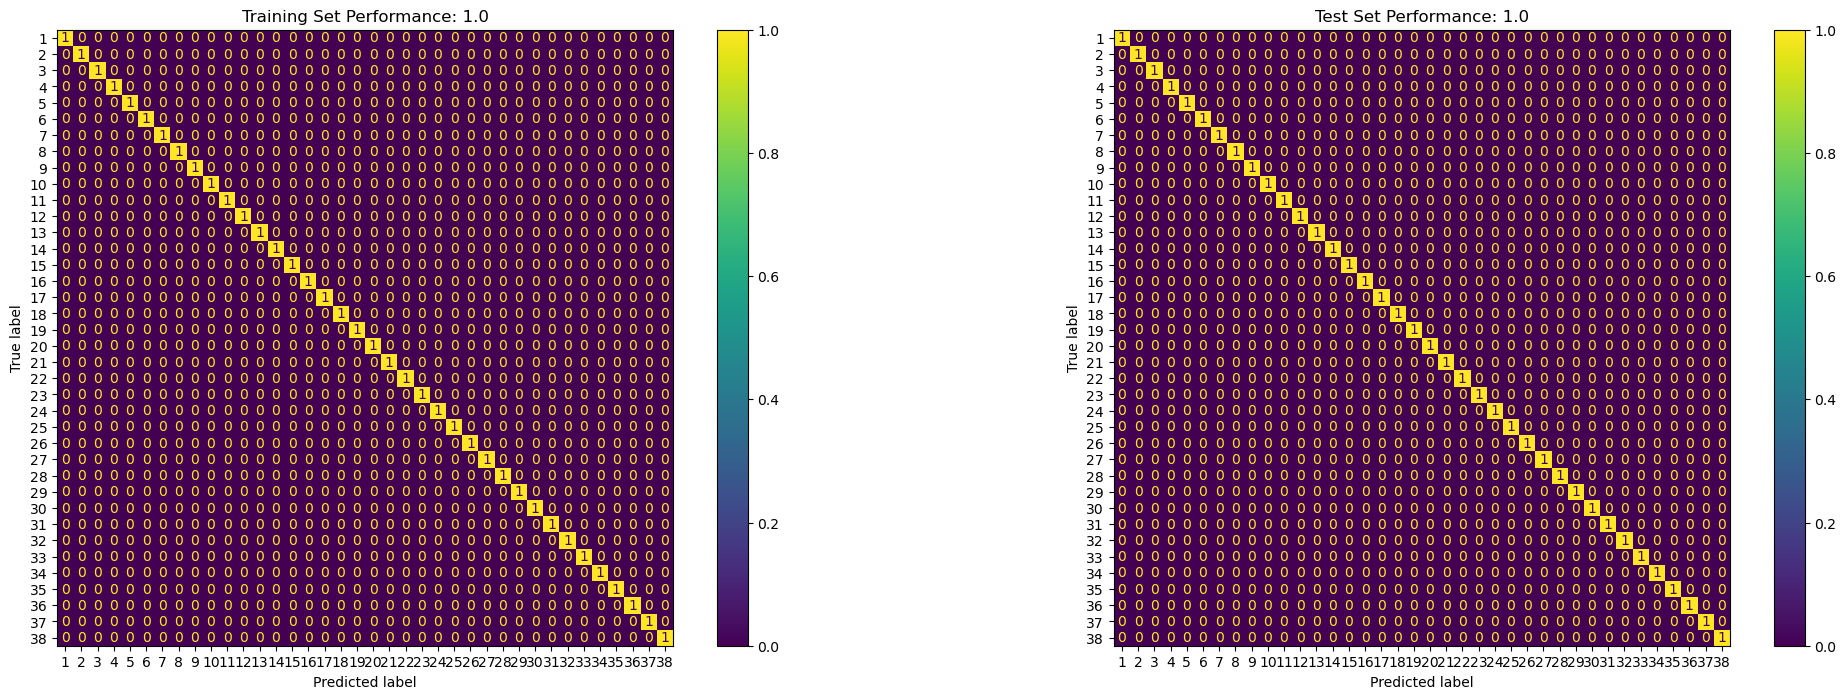

In [10]:
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax)
    pred = model.predict(X_train)
    conf.ax_.set_title('Training Set Performance: %s' % (sum(pred == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    pred = model.predict(X_test)
    conf.ax_.set_title('Test Set Performance: %s' % (sum(pred == Y_test)/len(Y_test)));    

test_embeddings = base_network.predict(test_fea_reshape)
cknn_siam = KNeighborsClassifier(n_neighbors=10, weights='distance')
cknn_siam.fit(embeddings, train_gnd)
eval_model(cknn_siam, embeddings, train_gnd, test_embeddings, test_gnd)    

This has also worked very well, and in fact achieved perfect results. 

### Compared to PCA

To avoid trawling through last weeks solutions, we'll quickly repeat the PCA implementation here.

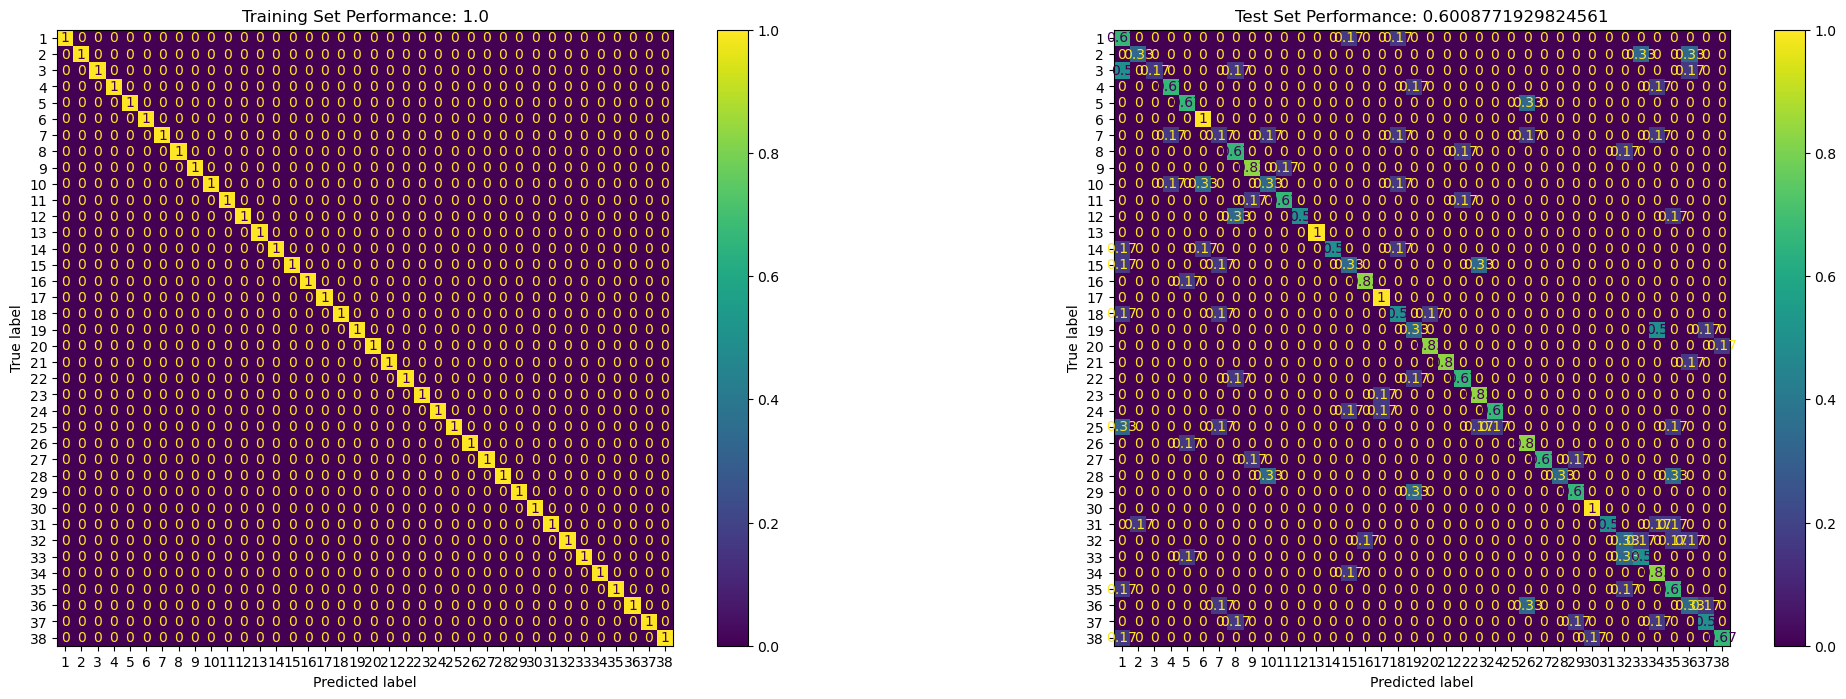

In [11]:
pca = decomposition.PCA()
pca.fit(train_fea)
transformed = pca.transform(train_fea)
transformed_test = pca.transform(test_fea)

cumulative_sum = numpy.cumsum(pca.explained_variance_ratio_, axis=0)
top95 = numpy.where(cumulative_sum > 0.95)[0][0]

transformed_train_95 = transformed[:, 0:top95]
transformed_test_95 = transformed_test[:, 0:top95]
    
cknn_95 = KNeighborsClassifier(n_neighbors=10, weights='distance')
cknn_95.fit(transformed_train_95, train_gnd)
eval_model(cknn_95, transformed_train_95, train_gnd, transformed_test_95, test_gnd)    

Our Siamese network wins.

### Compared to LDA

Let's also quickly compare to LDA, again just pulling code straight from last week.

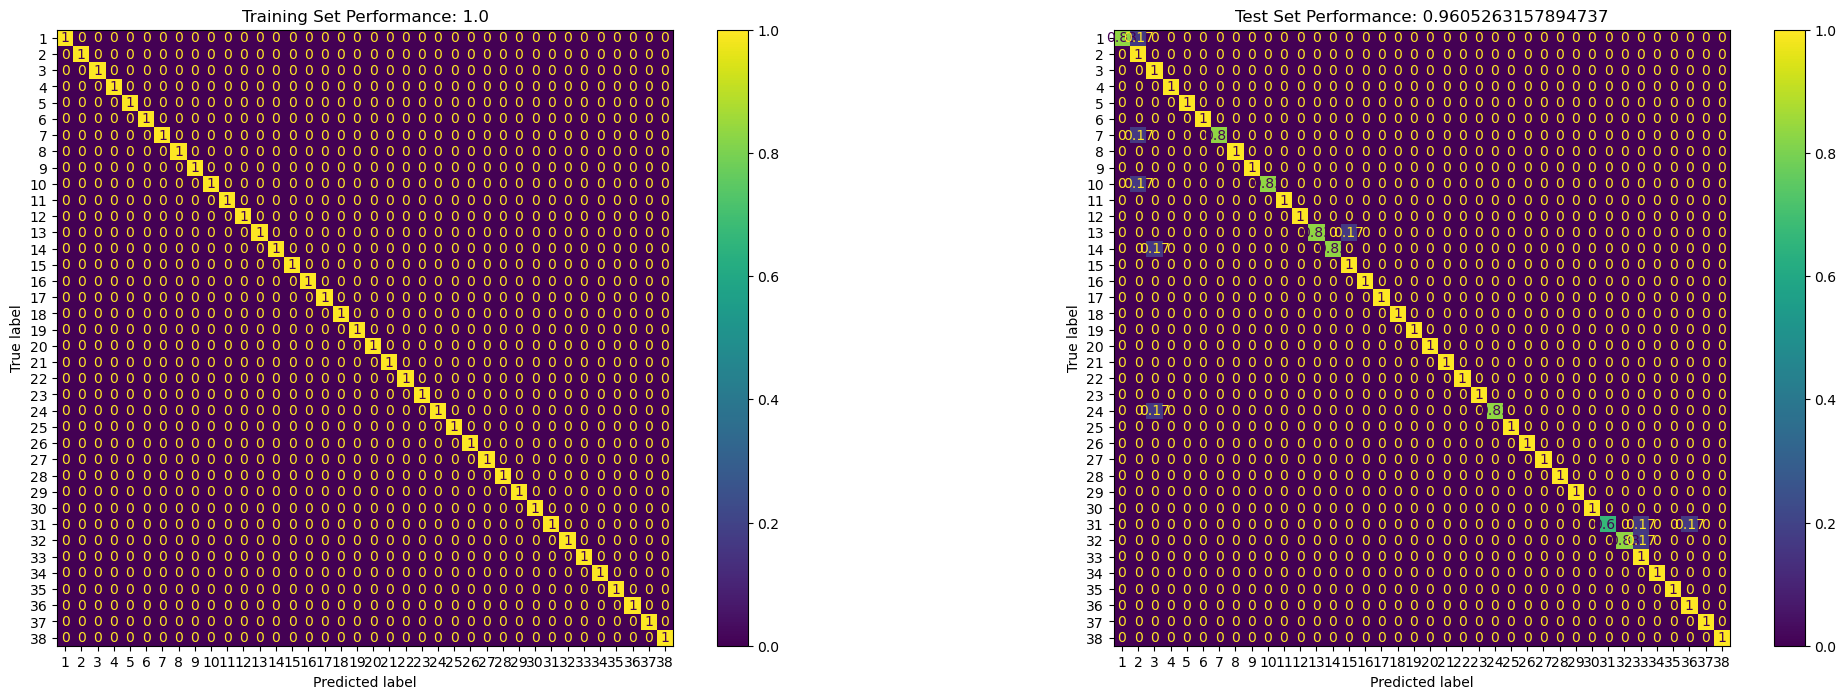

In [12]:
pca_coeff_for_lda = 1024 - len(numpy.unique(train_gnd))

transformed_train_for_lda = transformed[:, 0:pca_coeff_for_lda]
transformed_test_for_lda = transformed_test[:, 0:pca_coeff_for_lda]

lda = discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(numpy.array(transformed_train_for_lda), numpy.array(train_gnd))
transformed = lda.transform(transformed_train_for_lda)
transformed_test = lda.transform(transformed_test_for_lda)

cknn_lda = KNeighborsClassifier(n_neighbors=10, weights='distance')
cknn_lda.fit(transformed, train_gnd)
eval_model(cknn_lda, transformed, train_gnd, transformed_test, test_gnd)    

As per last week, we see that LDA works much better than PCA - but still not as good as our triplet network. Also note that our LDA model uses 37 dimensional features, while our triplet network is only using 32 (and we could probably make that smaller).

## Does it Generalise?

PCA did generalise somewhat, PDA didn't really. What about our deep network?

### ORL

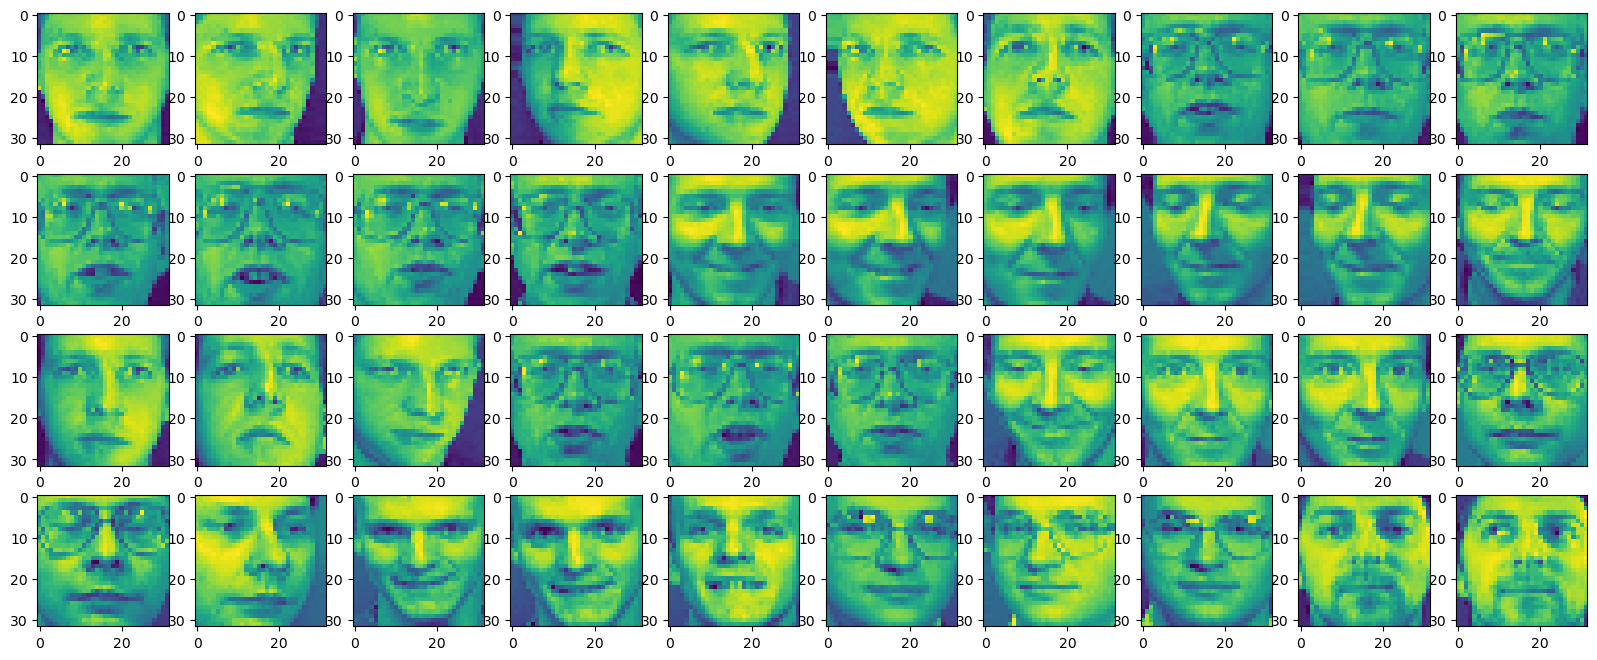

In [13]:
orl = scipy.io.loadmat('ORL_32x32.mat');
fea = orl['fea'] / 255.0
gnd = numpy.array(orl['gnd'])

train_frames = []
for i in range(40):
    for j in range(7):
        train_frames.append(i*10 + j)
        
train_orl_fea = fea[train_frames, :]
train_orl_gnd = gnd[train_frames, :]
test_orl_fea = fea
test_orl_gnd = gnd
test_orl_fea = numpy.delete(test_orl_fea, train_frames, 0)
test_orl_gnd = numpy.delete(test_orl_gnd, train_frames, 0)
train_orl_gnd = numpy.reshape(train_orl_gnd, -1)
test_orl_gnd = numpy.reshape(test_orl_gnd, -1)

train_fea_reshape = numpy.reshape(train_orl_fea.transpose(), (32, 32, 1, len(train_orl_fea)))
train_fea_reshape = numpy.transpose(train_fea_reshape, (3, 1, 0, 2))
test_fea_reshape = numpy.reshape(test_orl_fea.transpose(), (32, 32, 1, len(test_orl_fea)))
test_fea_reshape = numpy.transpose(test_fea_reshape, (3, 1, 0, 2))

fig = plt.figure(figsize=[20, 8])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(train_fea_reshape[i,:,:,0])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 21)
    ax.imshow(test_fea_reshape[i,:,:,0])    

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step


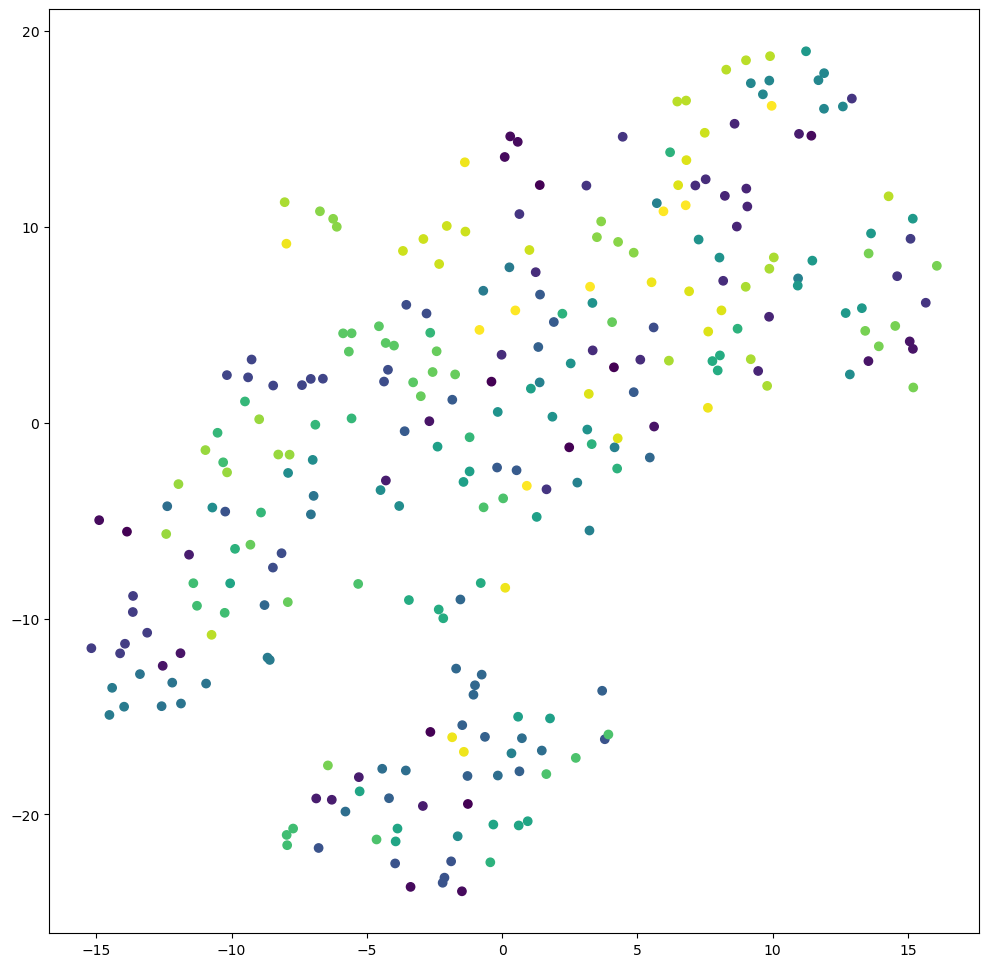

In [14]:
embeddings = base_network.predict(train_fea_reshape)
tsne_embeddings = TSNE(random_state=4).fit_transform(embeddings)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = train_orl_gnd.flatten());

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


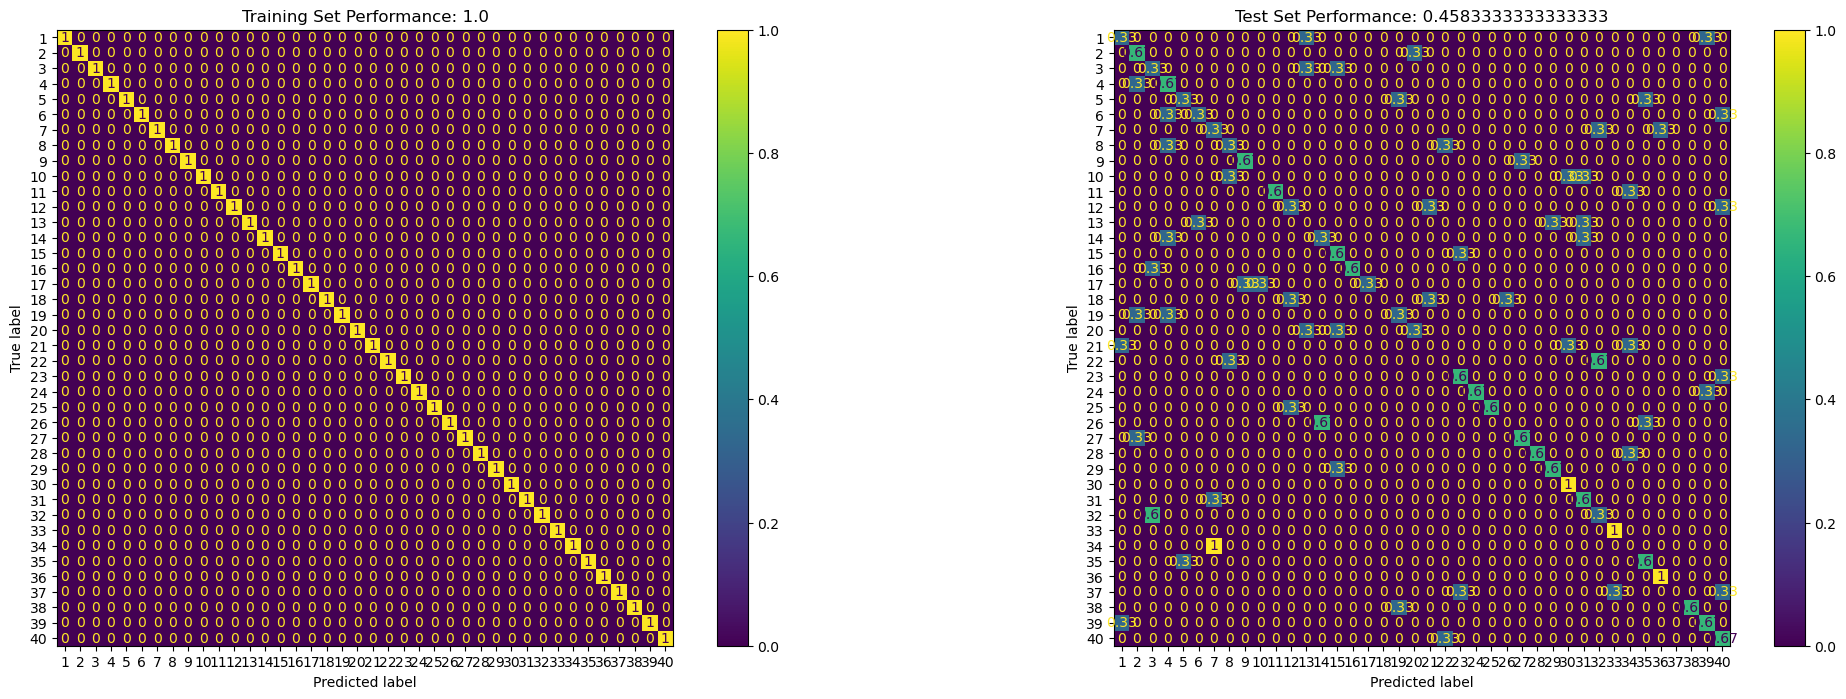

In [15]:
test_embeddings = base_network.predict(test_fea_reshape)
cknn_siam = KNeighborsClassifier(n_neighbors=3, weights='distance')
cknn_siam.fit(embeddings, train_orl_gnd)
eval_model(cknn_siam, embeddings, train_orl_gnd, test_embeddings, test_orl_gnd) 

### Yale

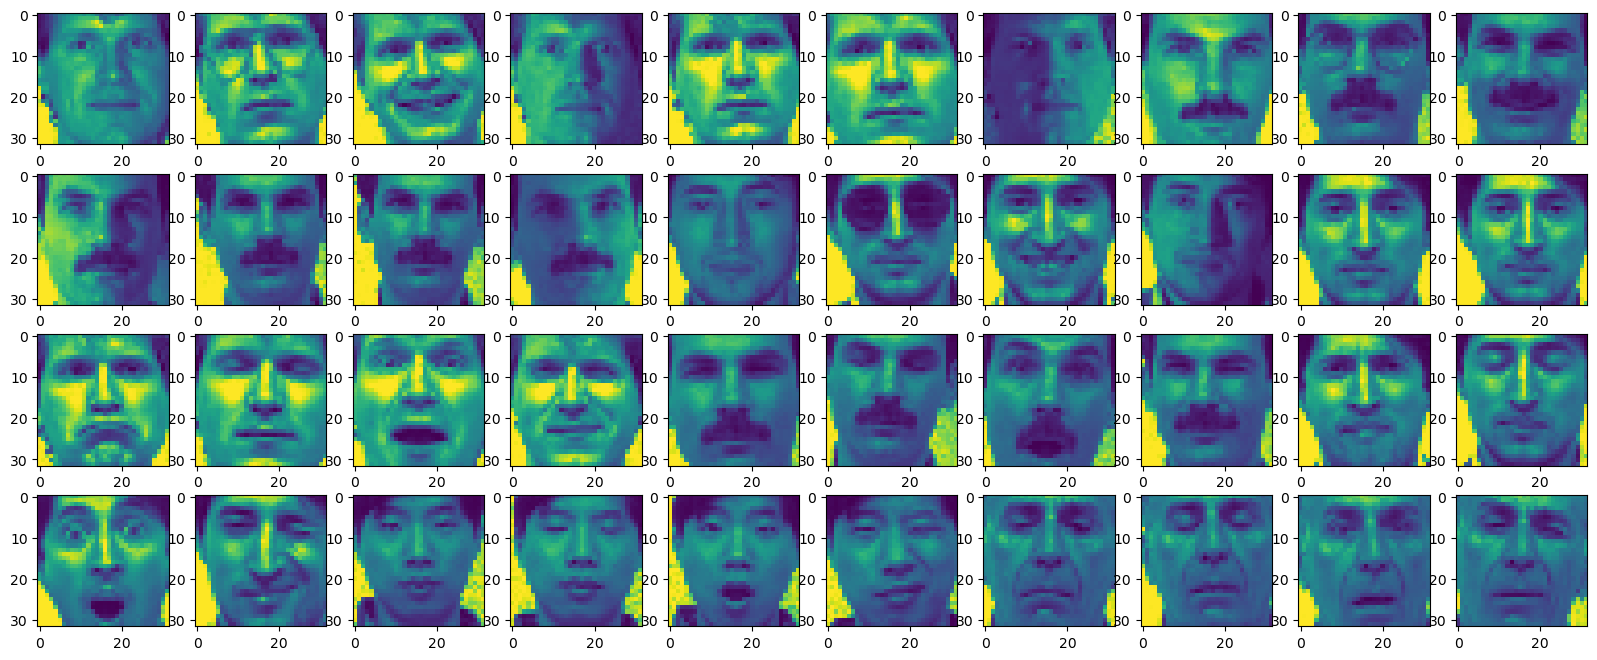

In [16]:
yale = scipy.io.loadmat('Yale_32x32.mat');
fea = yale['fea'] / 255.0
gnd = numpy.array(yale['gnd'])

train_frames = []
for i in range(15):
    for j in range(7):
        train_frames.append(i*11 + j)

train_yale_fea = fea[train_frames, :]
train_yale_gnd = gnd[train_frames, :]
test_yale_fea = fea
test_yale_gnd = gnd
test_yale_fea = numpy.delete(test_yale_fea, train_frames, 0)
test_yale_gnd = numpy.delete(test_yale_gnd, train_frames, 0)
train_yale_gnd = numpy.reshape(train_yale_gnd, -1)
test_yale_gnd = numpy.reshape(test_yale_gnd, -1)

train_fea_reshape = numpy.reshape(train_yale_fea.transpose(), (32, 32, 1, len(train_yale_fea)))
train_fea_reshape = numpy.transpose(train_fea_reshape, (3, 1, 0, 2))
test_fea_reshape = numpy.reshape(test_yale_fea.transpose(), (32, 32, 1, len(test_yale_fea)))
test_fea_reshape = numpy.transpose(test_fea_reshape, (3, 1, 0, 2))

fig = plt.figure(figsize=[20, 8])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(train_fea_reshape[i,:,:,0])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 21)
    ax.imshow(test_fea_reshape[i,:,:,0])   

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step


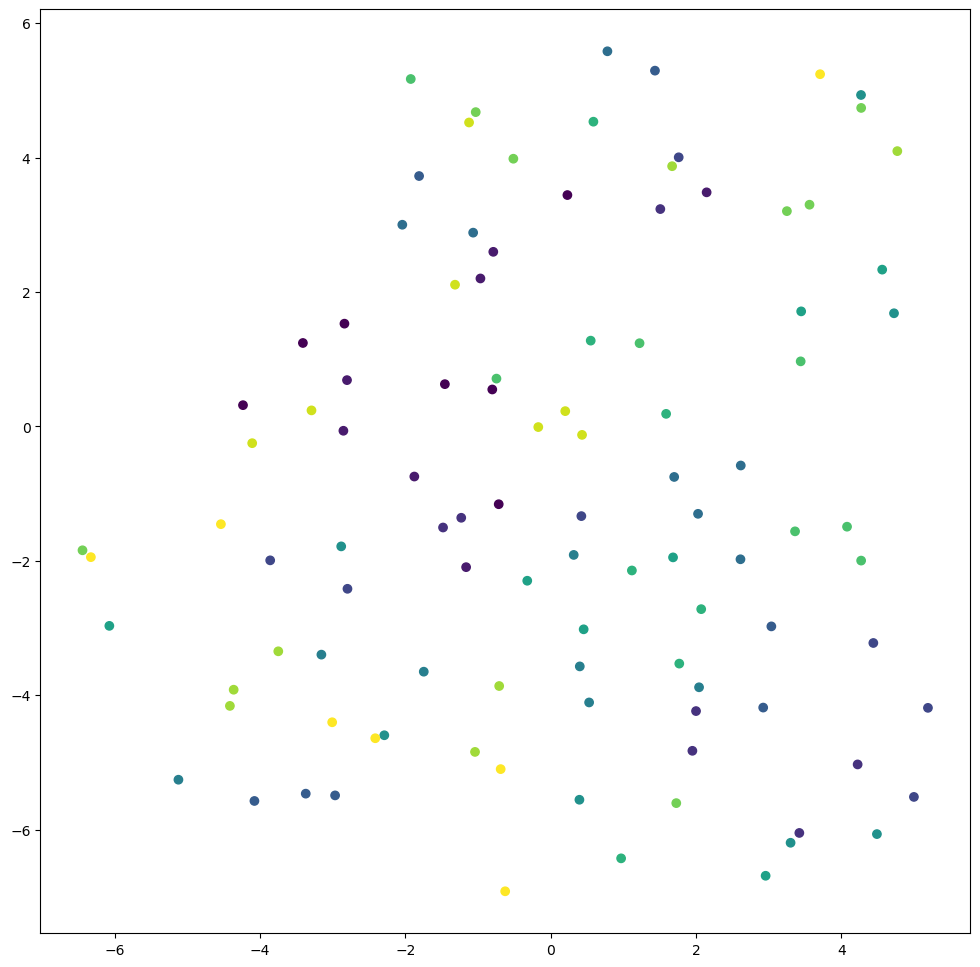

In [17]:
embeddings = base_network.predict(train_fea_reshape)
tsne_embeddings = TSNE(random_state=4).fit_transform(embeddings)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = train_yale_gnd.flatten());

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step


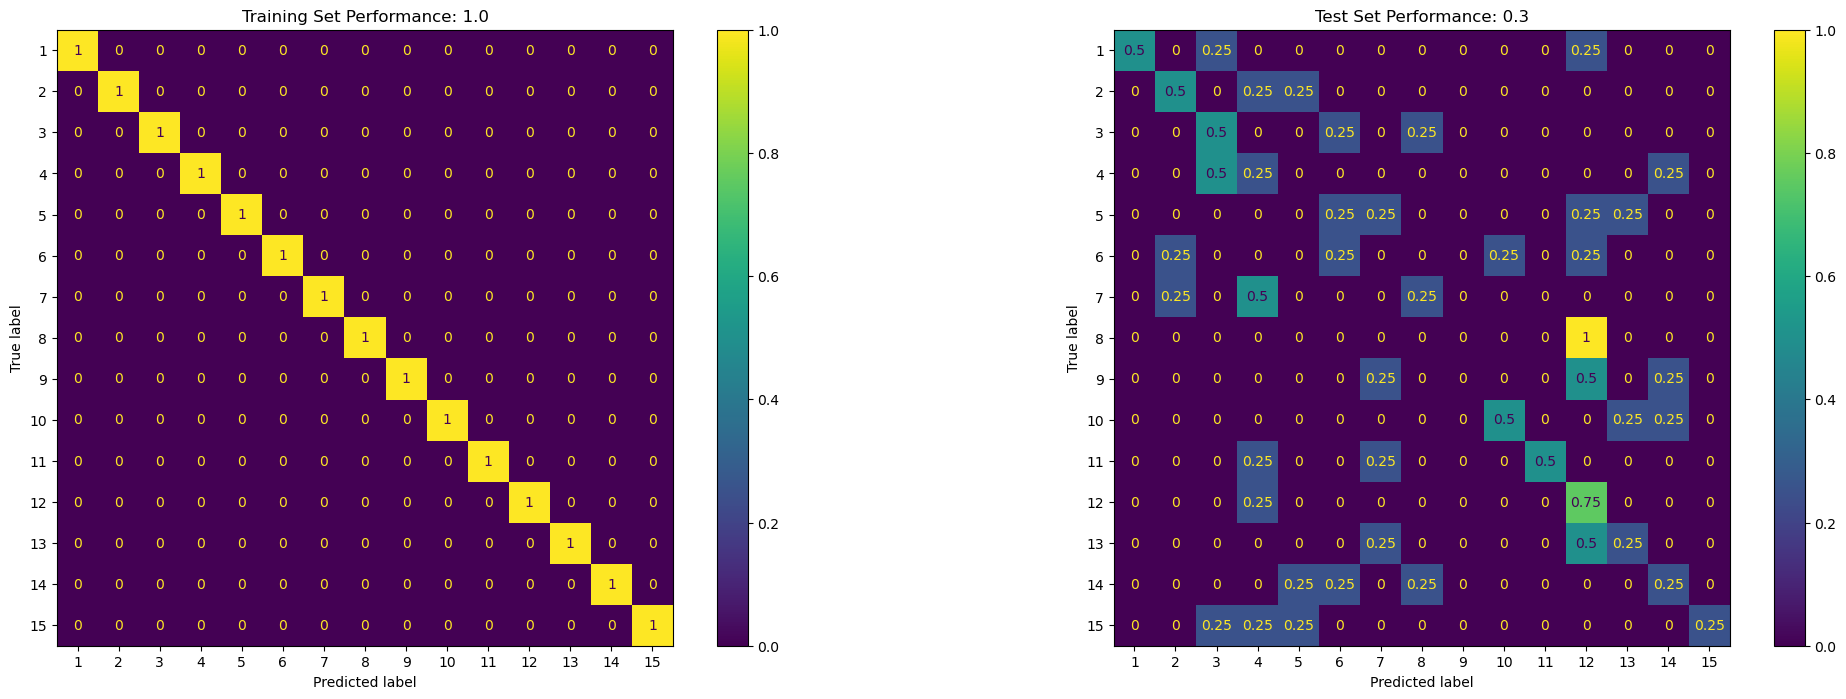

In [18]:
test_embeddings = base_network.predict(test_fea_reshape)
cknn_siam = KNeighborsClassifier(n_neighbors=3, weights='distance')
cknn_siam.fit(embeddings, train_yale_gnd)
eval_model(cknn_siam, embeddings, train_yale_gnd, test_embeddings, test_yale_gnd) 

### Did it Generalise?

Not really - but maybe a little bit - and probably better than LDA.

The problem here is that, aside from the slight domain shift between datasets, is that our model simply hasn't seen that many faces (it's seen 38). Ideally, we'd be able to split our data such that the train and test set contained completely separate faces, which would give a far better indication of performance.

## Final Thoughts

We see that for well matched data, our Siamese network approach can give us far better performance than PCA or LDA, but it is still sensitive to the amount and diversity of data that it sees. In this case, we see that we simply don't have enough diversity in the data for it to generalise well.

More data can overcome this, but DCNNs are also prone to overfitting - they are naturally over-parameterised. Thus this is something that needs to be kept an eye on. Better data splits, where a group of subjects are kept for the test set only, and which isn't really possible with the data we have, also help to measure how well a model is generalising.